## Installation

In [ ]:
!python -m pip install keras_cv datasets transformers tensorboard tensorflow ipywidgets opencv-python tensorflow-datasets scikit-learn
!git-lfs --version

Login to huggingface if first time

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Show that the GPU is being used

In [1]:
from tensorflow.config.experimental import list_physical_devices
print(list_physical_devices('GPU'))

model_id = "google/vit-base-patch16-224-in21k"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Now create the database, also this is the time to define data augmentation

In [2]:
from transformers import ViTImageProcessor
from datasets import load_dataset
from tensorflow import device
from tensorflow import keras
from tensorflow.keras import layers
from keras_cv.layers import RandAugment
import tensorflow as tf

# Define the model ID and other parameters
num_layers = 2
magnitude = 0.15

# Load the ViTImageProcessor
image_processor = ViTImageProcessor.from_pretrained(model_id)

# Create RandAugment transformation
rand_augment = RandAugment(
    value_range=[-1,1],
    augmentations_per_image=num_layers,
    magnitude=magnitude,
)


def transform(batch):
    inputs = image_processor([x for x in batch["image"]], return_tensors="tf")
    inputs["labels"] = batch["label"]
    return inputs

def augment(batch):
    inputs = image_processor([x for x in batch["image"]], return_tensors="tf")
    transposed = tf.transpose(inputs["pixel_values"], perm=[0,3,2,1])
    with device('/cpu:0'):
        augmented = rand_augment(transposed)
    inputs["pixel_values"] = tf.transpose(augmented, perm=[0,3,2,1])
    inputs["labels"] = batch["label"]
    return inputs

dataset = load_dataset("streetview_images_cropped", data_dir="./")

eval_size=.15
test_size=.05

dataset = dataset["train"].shuffle().train_test_split(test_size=test_size)
dataset_final_test = dataset['test'].with_transform(transform)

dataset = dataset["train"].train_test_split(test_size=eval_size)
dataset['train'] = dataset['train'].with_transform(augment)
dataset['test'] = dataset['test'].with_transform(transform)
processed_dataset = dataset

Using TensorFlow backend


Resolving data files:   0%|          | 0/42570 [00:00<?, ?it/s]

Specify hyperparameters

In [3]:
from huggingface_hub import HfFolder
import tensorflow as tf

class_labels = processed_dataset['train'].features["label"].names
num_images_train = processed_dataset['train'].num_rows
id2label = {str(i): label for i, label in enumerate(class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 32
learning_rate = 6e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token()
hub_model_id = f'dl-au-tamas-jedrek/{model_id.split("/")[1]}-street-view'


In [4]:
import json

with open("data/distances.json", "r") as infile:
    distances = json.load(infile)

#make matrix with label2id
import numpy as np
mat_distances = np.zeros((len(label2id), len(label2id)))
for key in distances.keys():
    for key2 in distances[key].keys():
        mat_distances[int(label2id[key])][int(label2id[key2])] = distances[key][key2]
mat_distances

array([[  0.        , 229.02150892, 228.10446099, ..., 157.48504833,
        168.92791079,  68.51475158],
       [229.02150892,   0.        ,   3.83173362, ...,  72.6392153 ,
        257.10553454, 242.08400282],
       [228.10446099,   3.83173362,   0.        , ...,  71.2555174 ,
        258.7988651 , 242.2555515 ],
       ...,
       [157.48504833,  72.6392153 ,  71.2555174 , ...,   0.        ,
        215.85521045, 178.68501914],
       [168.92791079, 257.10553454, 258.7988651 , ..., 215.85521045,
          0.        , 103.66397521],
       [ 68.51475158, 242.08400282, 242.2555515 , ..., 178.68501914,
        103.66397521,   0.        ]])

Get model, specify loss and metrics

In [5]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = num_images_train * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(class_labels),
    id2label=id2label,
    label2id=label2id,
)

tensor_distances = tf.convert_to_tensor(mat_distances, dtype=tf.float32)
def customLoss(y_true, y_pred):
    y_pred_label = tf.argmax(y_pred, axis=1)
    y_true = tf.reshape(y_true, [-1])
    indices = tf.stack((y_true, y_pred_label), axis=1)
    dist = tf.gather_nd(tensor_distances, indices)
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True) + (dist ** 2)/50
# define loss
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = customLoss

def distanceMetric(y_true, y_pred):
    y_pred_label = tf.argmax(y_pred, axis=1)
    y_true = tf.reshape(y_true, [-1])
    y_true = tf.cast(y_true, tf.int64)
    indices = tf.stack((y_true, y_pred_label), axis=1)
    dist = tf.gather_nd(tensor_distances, indices)
    return tf.reduce_mean(dist)

# define metrics 
metrics=[
    distanceMetric,
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

2023-11-19 17:09:33.365939: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-19 17:09:33.365972: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 17:09:33.365977: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 17:09:33.366020: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-19 17:09:33.366045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bi

In [6]:
model.vit.embeddings.trainable = True
model.summary()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  99201     
                                                                 
Total params: 85897857 (327.67 MB)
Trainable params: 85897857 (327.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Transform dataset for training

In [7]:
tf_train_dataset = model.prepare_tf_dataset(processed_dataset['train'], batch_size=train_batch_size, shuffle=True)
tf_eval_dataset = model.prepare_tf_dataset(processed_dataset['test'], batch_size=eval_batch_size, shuffle=True)
tf_test_dataset = model.prepare_tf_dataset(dataset_final_test, batch_size=eval_batch_size, shuffle=True)

Run to display train images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


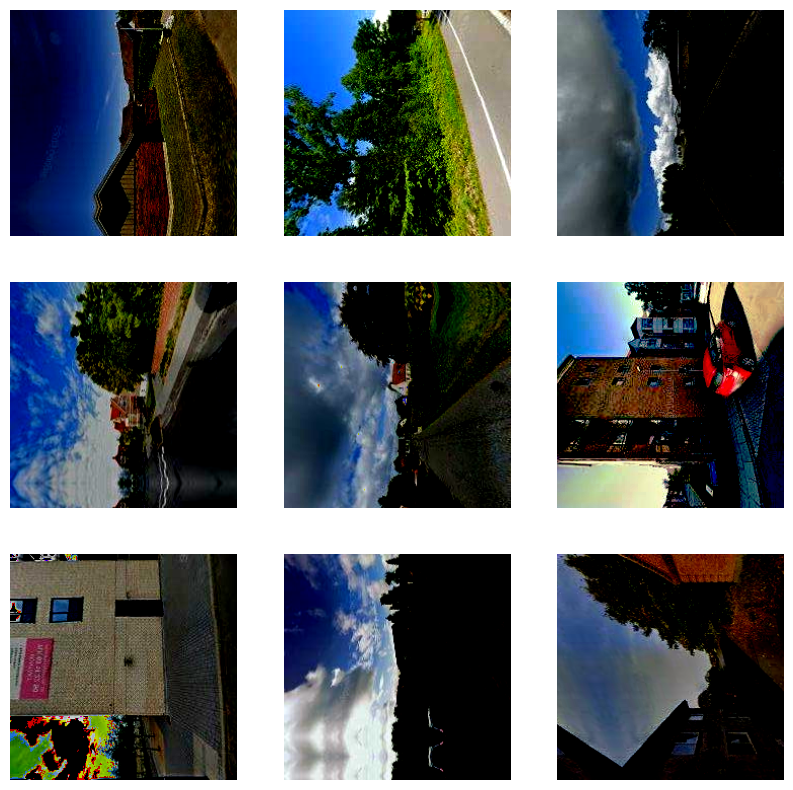

In [8]:
import matplotlib.pyplot as plt

sample_images, sample_labels = next(iter(tf_train_dataset))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    transposed = tf.transpose(image)
    plt.imshow(transposed.numpy())
    plt.axis("off")

Push metrics to hub after every epoch

In [9]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks = []
callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir, "logs")))
#callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))
callbacks.append(PushToHubCallback(
    output_dir,
    hub_model_id=hub_model_id,
    hub_token=hub_token,
))



/Users/au724747/projects/dl-geolocation-vit/vit-base-patch16-224-in21k is already a clone of https://huggingface.co/dl-au-tamas-jedrek/vit-base-patch16-224-in21k-street-view. Make sure you pull the latest changes with `repo.git_pull()`.


Train model

In [10]:
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_info()
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
    verbose=1
)

Epoch 1/5


2023-11-19 17:09:44.467905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1074/1074 [==============================] - ETA: 0s - loss: 407.5616 - distanceMetric: 113.7399 - accuracy: 0.0584 - top-3-accuracy: 0.1272

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3115s 3s/step - loss: 407.5616 - distanceMetric: 113.7399 - accuracy: 0.0584 - top-3-accuracy: 0.1272 - val_loss: 371.6254 - val_distanceMetric: 104.2261 - val_accuracy: 0.1004 - val_top-3-accuracy: 0.2077
Epoch 2/5
1074/1074 [==============================] - ETA: 0s - loss: 337.8405 - distanceMetric: 96.8124 - accuracy: 0.1255 - top-3-accuracy: 0.2485

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3087s 3s/step - loss: 337.8405 - distanceMetric: 96.8124 - accuracy: 0.1255 - top-3-accuracy: 0.2485 - val_loss: 326.3704 - val_distanceMetric: 93.2724 - val_accuracy: 0.1543 - val_top-3-accuracy: 0.2897
Epoch 3/5
1074/1074 [==============================] - ETA: 0s - loss: 289.1537 - distanceMetric: 84.9479 - accuracy: 0.1938 - top-3-accuracy: 0.3490

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2979s 3s/step - loss: 289.1537 - distanceMetric: 84.9479 - accuracy: 0.1938 - top-3-accuracy: 0.3490 - val_loss: 278.8913 - val_distanceMetric: 82.1711 - val_accuracy: 0.2102 - val_top-3-accuracy: 0.3709
Epoch 4/5
1074/1074 [==============================] - ETA: 0s - loss: 246.8456 - distanceMetric: 73.9707 - accuracy: 0.2702 - top-3-accuracy: 0.4518

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 2982s 3s/step - loss: 246.8456 - distanceMetric: 73.9707 - accuracy: 0.2702 - top-3-accuracy: 0.4518 - val_loss: 256.3440 - val_distanceMetric: 76.1286 - val_accuracy: 0.2546 - val_top-3-accuracy: 0.4221
Epoch 5/5
1074/1074 [==============================] - ETA: 0s - loss: 202.5460 - distanceMetric: 62.5650 - accuracy: 0.3497 - top-3-accuracy: 0.5506

Configuration saved in vit-base-patch16-224-in21k/config.json
Model weights saved in vit-base-patch16-224-in21k/tf_model.h5


1074/1074 [==============================] - 3051s 3s/step - loss: 202.5460 - distanceMetric: 62.5650 - accuracy: 0.3497 - top-3-accuracy: 0.5506 - val_loss: 228.8270 - val_distanceMetric: 70.0395 - val_accuracy: 0.2793 - val_top-3-accuracy: 0.4545


## Confusion Matrix

1/1 [==============================] - 4s 4s/step
[ 40  41 118  21 103  72  57  40  68 123  73  41  29 118  98  83 118 109
 124  78 110  51  87 127  54  61  71 102  80  87  88 107]
[109  46 118  21 103  72 113  18  68  32  73  26  29  80  15  83 118  93
  99  78  43  51  88 108  54  20   9  37  95  90  16 114]
1/1 [==============================] - 1s 781ms/step
[ 40 110  41  11  20  87   6 115  24  61  26  79  20  19  43  40  73  15
  57  72  60   6  40  70  50  55  74  78  52  57  50  19]
[ 56 110  63  11  20  16  97  80  24 114  48  77  88  89  76  88   9 109
  57  95 113  84  78  70  58  55  74  61  76  57  22  97]
1/1 [==============================] - 0s 484ms/step
[126  82  32  11 100  46  71  19 119  58 104  39  91  68  95  76  79   4
  72 110   4  18  14  61  40  60  49  54  34 115 128  30]
[ 90  82  16 122 100 106  71  60 119  56 124  39  91  68  70 107 116   1
  66  38   4  38  14 118  78  86  42  39  34  84  87  55]
1/1 [==============================] - 1s 881ms/step
[ 28 

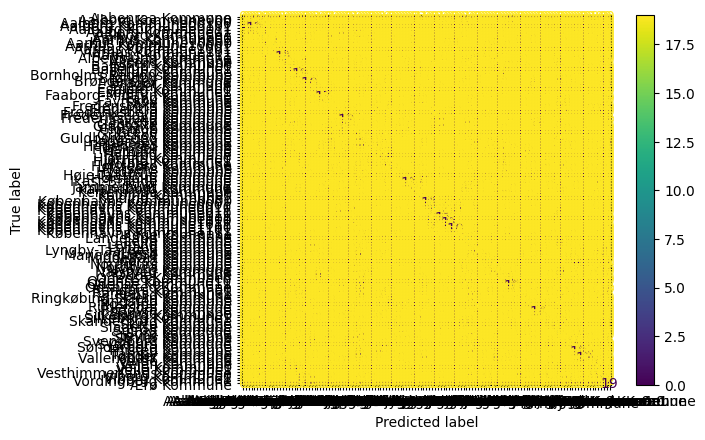

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

predictions = np.array([])
true_labels = np.array([])

for x, y in tf_test_dataset:
    y_prob = model.predict(x)
    # Apply softmax to obtain probabilities
    probabilities = tf.nn.softmax(y_prob.logits, axis=-1).numpy()
    # Get the predicted labels (class with the highest probability)
    y_pred = tf.argmax(probabilities, axis=-1).numpy()

    predictions = np.concatenate([predictions, y_pred])
    print(y_pred)
    print(y.numpy())
    true_labels = np.concatenate([true_labels, y.numpy()])

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.show()